<a href="https://colab.research.google.com/github/SantoshAhirrao/Document-Clustering/blob/main/Faktion_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Colab Preparation

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:

downloaded = drive.CreateFile({'id':'1nWgnHY7sVoptRBg2HRIoYnwGmZhikrbE'}) # replace the id with id of file you want to access
downloaded.GetContentFile('df.tsv') 

Jupyter Notebook

Import Libs

### 1. Loading and cleaning data

In [ ]:
# Import libraries
from collections import defaultdict,Counter
import importlib,math
from importlib import reload  
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scipy
from scipy import stats
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from scipy.sparse.linalg import norm
from sklearn import cluster,metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import paired_distances,cosine_similarity,cosine_distances,paired_euclidean_distances
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors.kde import KernelDensity
import regex as re

from sklearn.feature_selection import VarianceThreshold
pd.options.display.max_columns=201
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
pd.set_option('display.max_columns', None)   # To see all the columns of data frame

In [ ]:
df = pd.read_csv("df.tsv", sep='\t', header = None)

In [ ]:
df.head(2)

0  \
0  008482cf51383c158b54e593cfa5fbf7.pdf   
1  009fab39d746267b6de8428366fe4b02.pdf   

                                                   1  \
0  address__post_town address__postcode address__...   
1  address__post_town address__postcode address__...   

                                                   2  \
0  TAR\n1\nAugust 2016\nTrustees' Annual Report f...   
1  \fAnnual Report 2015-2017 July, 2017\nStepping...   

                                                   3  \
0  CHARITY Trustees’' Annual Report for the perio...   
1  \n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...   

                                                   4  \
0  CHARITY\nTrustees' Annual Report for the perio...   
1  Charity Name\nNo lif anv)\nStepping Stone Thea...   

                                                   5  
0  TAR\n1\nAugust 2016\nTrustees' Annual Report f...  
1  \n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...

In [ ]:
df.rename(columns={0:'filename', 1:'keys', 2:'text_djvu', 3:'text_tesseract', 4:'text_textract', 5:'text_best'}, inplace=True)

In [ ]:
df.head(3)

filename  \
0  008482cf51383c158b54e593cfa5fbf7.pdf   
1  009fab39d746267b6de8428366fe4b02.pdf   
2  01c7fd563327947c68abdd9717ef228d.pdf   

                                                keys  \
0  address__post_town address__postcode address__...   
1  address__post_town address__postcode address__...   
2  address__post_town address__postcode address__...   

                                           text_djvu  \
0  TAR\n1\nAugust 2016\nTrustees' Annual Report f...   
1  \fAnnual Report 2015-2017 July, 2017\nStepping...   
2  Promoting Independent Living\nCelebrating new\...   

                                      text_tesseract  \
0  CHARITY Trustees’' Annual Report for the perio...   
1  \n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...   
2  54 S ke *\nB\n \nWelcome to our Annual\nReport...   

                                       text_textract  \
0  CHARITY\nTrustees' Annual Report for the perio...   
1  Charity Name\nNo lif anv)\nStepping Stone Thea...   
2  Promoting Independent Living\nAbility\nAbility...   

                                           text_best  
0  TAR\n1\nAugust 2016\nTrustees' Annual Report f...  
1  \n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...  
2  54 S ke *\nB\n \nWelcome to our Annual\nReport...

In [ ]:
df['text_djvu'][0]

"TAR\\n1\\nAugust 2016\\nTrustees' Annual Report for the period\\nFrom\\nPeriod start date\\nTo\\nPeriod end date\\n30\\n04\\n2015\\n29\\n04\\n2016\\nSection A\\nReference and administration details\\nCharity name\\nPC Nicola Hughes Memorial Fund\\nOther names charity is known by\\nRegistered charity number (if any) 1156398\\nCharity's principal address Unit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode\\nOL3 5DE\\nNames of the charity trustees who manage the charity\\nTrustee name\\nOffice (if any)\\nDates acted if not for whole\\nyear\\nName of person (or body) entitled\\nto appoint trustee (if any)\\n1 Bryndon Hughes Chair\\n2\\n3\\n4\\n5\\n6\\n7\\n8\\n9\\n10\\n11\\n12\\n13\\n14\\n15\\n16\\n17\\nNames of the trustees for the charity, if any, (for example, any custodian trustees)\\nName\\nDates acted if not for whole year\\nRichard Bartlett\\nMark Brook\\nTAR\\n2\\nAugust 2016\\nNames and addresses of advisers (Optional information)\\nType of adviser\\nName\

In [ ]:
df['text_tesseract'][0]

"CHARITY Trustees’' Annual Report for the period\\n(OMMIsSIoN Period start date Period end date\\ng From To\\nSection A Reference and administration details\\n \\n \\nCharity name‘ PC Nicola Hughes Memorial Fund\\nOther names charity is known by\\nRegistered charity number (if any)|1156398\\nCharity's principal address |Unit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode ‘0L3 5DE\\n \\n \\n \\n \\n \\n \\n \\n \\n \\nNames of the charity trustees who manage the charity Dates acted if not for whole Name of person (or body) entitled  \\n \\n \\nName Dates acted if not for whole year\\nRichard Bartlett\\nMark Brook\\n \\nTAR 1 August 2016\\nNames and addresses of advisers (Optional information)\\n \\nType of adviser Name Address\\nLegal Advisor John Ainley North Ainley Halliwell Solicitors, Clegg St, Oldham, OL1 1PS\\nAccountant David Richardson Richardson Accountancy\\n \\n \\n \\n \\n \\nName of chief executive or names of senior staff members (Optional informat

In [ ]:
df['text_textract'][0]

"CHARITY\\nTrustees' Annual Report for the period\\nCOMMISSION\\nPeriod start date\\nPeriod end date\\n30\\n04\\n2015\\n29\\n04\\n2016\\nFrom\\nTo\\nSection A\\nReference and administration details\\nCharity name\\nPC Nicola Hughes Memorial und\\nOther names charity is known by\\nRegistered charity number (if any)\\n1156398\\nCharity's principal address\\nUnit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode\\nOL3 5DE\\nNames of the charity trustees who manage the charity\\nTrustee name\\nOffice (if any)\\nDates acted if not for whole\\nName of person (or body) entitled\\nyear\\nto appoint trustee (if any)\\n1\\nBryndon Hughes\\nChair\\n2\\n3\\n4\\n5\\n6\\n7\\n8\\n9\\n10\\n11\\n12\\n13\\n14\\n15\\n16\\n17\\nNames of the trustees for the charity, if any, (for example, any custodian trustees)\\nName\\nDates acted if not for whole year\\nRichard Bartlett\\nMark Brook\\nTAR\\n1\\nAugust 2016\\nNames and addresses of advisers (Optional information)\\nType of adviser\\

In [ ]:
df['text_best'][0]

"TAR\\n1\\nAugust 2016\\nTrustees' Annual Report for the period\\nFrom\\nPeriod start date\\nTo\\nPeriod end date\\n30\\n04\\n2015\\n29\\n04\\n2016\\nSection A\\nReference and administration details\\nCharity name\\nPC Nicola Hughes Memorial Fund\\nOther names charity is known by\\nRegistered charity number (if any) 1156398\\nCharity's principal address Unit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode\\nOL3 5DE\\nNames of the charity trustees who manage the charity\\nTrustee name\\nOffice (if any)\\nDates acted if not for whole\\nyear\\nName of person (or body) entitled\\nto appoint trustee (if any)\\n1 Bryndon Hughes Chair\\n2\\n3\\n4\\n5\\n6\\n7\\n8\\n9\\n10\\n11\\n12\\n13\\n14\\n15\\n16\\n17\\nNames of the trustees for the charity, if any, (for example, any custodian trustees)\\nName\\nDates acted if not for whole year\\nRichard Bartlett\\nMark Brook\\nTAR\\n2\\nAugust 2016\\nNames and addresses of advisers (Optional information)\\nType of adviser\\nName\

In [ ]:
df['keys'].unique()

array(['address__post_town address__postcode address__street_line charity_name charity_number income_annually_in_british_pounds report_date spending_annually_in_british_pounds'],
      dtype=object)

In [ ]:
df['text_djvu'].unique()

array(["TAR\\n1\\nAugust 2016\\nTrustees' Annual Report for the period\\nFrom\\nPeriod start date\\nTo\\nPeriod end date\\n30\\n04\\n2015\\n29\\n04\\n2016\\nSection A\\nReference and administration details\\nCharity name\\nPC Nicola Hughes Memorial Fund\\nOther names charity is known by\\nRegistered charity number (if any) 1156398\\nCharity's principal address Unit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode\\nOL3 5DE\\nNames of the charity trustees who manage the charity\\nTrustee name\\nOffice (if any)\\nDates acted if not for whole\\nyear\\nName of person (or body) entitled\\nto appoint trustee (if any)\\n1 Bryndon Hughes Chair\\n2\\n3\\n4\\n5\\n6\\n7\\n8\\n9\\n10\\n11\\n12\\n13\\n14\\n15\\n16\\n17\\nNames of the trustees for the charity, if any, (for example, any custodian trustees)\\nName\\nDates acted if not for whole year\\nRichard Bartlett\\nMark Brook\\nTAR\\n2\\nAugust 2016\\nNames and addresses of advisers (Optional information)\\nType of adviser\

In [ ]:
df['text_tesseract'].unique()

array(["CHARITY Trustees’' Annual Report for the period\\n(OMMIsSIoN Period start date Period end date\\ng From To\\nSection A Reference and administration details\\n \\n \\nCharity name‘ PC Nicola Hughes Memorial Fund\\nOther names charity is known by\\nRegistered charity number (if any)|1156398\\nCharity's principal address |Unit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode ‘0L3 5DE\\n \\n \\n \\n \\n \\n \\n \\n \\n \\nNames of the charity trustees who manage the charity Dates acted if not for whole Name of person (or body) entitled  \\n \\n \\nName Dates acted if not for whole year\\nRichard Bartlett\\nMark Brook\\n \\nTAR 1 August 2016\\nNames and addresses of advisers (Optional information)\\n \\nType of adviser Name Address\\nLegal Advisor John Ainley North Ainley Halliwell Solicitors, Clegg St, Oldham, OL1 1PS\\nAccountant David Richardson Richardson Accountancy\\n \\n \\n \\n \\n \\nName of chief executive or names of senior staff members (Optional i

In [ ]:
df['text_textract'].unique()

array(["CHARITY\\nTrustees' Annual Report for the period\\nCOMMISSION\\nPeriod start date\\nPeriod end date\\n30\\n04\\n2015\\n29\\n04\\n2016\\nFrom\\nTo\\nSection A\\nReference and administration details\\nCharity name\\nPC Nicola Hughes Memorial und\\nOther names charity is known by\\nRegistered charity number (if any)\\n1156398\\nCharity's principal address\\nUnit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode\\nOL3 5DE\\nNames of the charity trustees who manage the charity\\nTrustee name\\nOffice (if any)\\nDates acted if not for whole\\nName of person (or body) entitled\\nyear\\nto appoint trustee (if any)\\n1\\nBryndon Hughes\\nChair\\n2\\n3\\n4\\n5\\n6\\n7\\n8\\n9\\n10\\n11\\n12\\n13\\n14\\n15\\n16\\n17\\nNames of the trustees for the charity, if any, (for example, any custodian trustees)\\nName\\nDates acted if not for whole year\\nRichard Bartlett\\nMark Brook\\nTAR\\n1\\nAugust 2016\\nNames and addresses of advisers (Optional information)\\nType of ad

In [ ]:
df['text_best'].unique()

array(["TAR\\n1\\nAugust 2016\\nTrustees' Annual Report for the period\\nFrom\\nPeriod start date\\nTo\\nPeriod end date\\n30\\n04\\n2015\\n29\\n04\\n2016\\nSection A\\nReference and administration details\\nCharity name\\nPC Nicola Hughes Memorial Fund\\nOther names charity is known by\\nRegistered charity number (if any) 1156398\\nCharity's principal address Unit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode\\nOL3 5DE\\nNames of the charity trustees who manage the charity\\nTrustee name\\nOffice (if any)\\nDates acted if not for whole\\nyear\\nName of person (or body) entitled\\nto appoint trustee (if any)\\n1 Bryndon Hughes Chair\\n2\\n3\\n4\\n5\\n6\\n7\\n8\\n9\\n10\\n11\\n12\\n13\\n14\\n15\\n16\\n17\\nNames of the trustees for the charity, if any, (for example, any custodian trustees)\\nName\\nDates acted if not for whole year\\nRichard Bartlett\\nMark Brook\\nTAR\\n2\\nAugust 2016\\nNames and addresses of advisers (Optional information)\\nType of adviser\

In [ ]:
df.shape

(1729, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   filename        1729 non-null   object
 1   keys            1729 non-null   object
 2   text_djvu       1684 non-null   object
 3   text_tesseract  1728 non-null   object
 4   text_textract   1728 non-null   object
 5   text_best       1729 non-null   object
dtypes: object(6)
memory usage: 81.2+ KB


In [ ]:
# checking possible values each variable can take and for stalk-root we notice that '?' is also a possible value.
for c in df.columns:    
    if (df[c].dtype==object):
        print("=============", c,df[c].unique())

============= filename ['008482cf51383c158b54e593cfa5fbf7.pdf'
 '009fab39d746267b6de8428366fe4b02.pdf'
 '01c7fd563327947c68abdd9717ef228d.pdf' ...
 'ffb1325d77fde527581429bb28322205.pdf'
 'ffbf63bf6483012f2fd0af6c77ab3da6.pdf'
 'ffcc30999650db76144fe4ff91b60e0e.pdf']
============= keys ['address__post_town address__postcode address__street_line charity_name charity_number income_annually_in_british_pounds report_date spending_annually_in_british_pounds']
============= text_djvu ["TAR\\n1\\nAugust 2016\\nTrustees' Annual Report for the period\\nFrom\\nPeriod start date\\nTo\\nPeriod end date\\n30\\n04\\n2015\\n29\\n04\\n2016\\nSection A\\nReference and administration details\\nCharity name\\nPC Nicola Hughes Memorial Fund\\nOther names charity is known by\\nRegistered charity number (if any) 1156398\\nCharity's principal address Unit 1, Block B, Gatehead business Park\\nDelph New Road\\nOldham\\nPostcode\\nOL3 5DE\\nNames of the charity trustees who manage the charity\\nTrustee name\\nO

In [ ]:
import nltk
from keras.preprocessing.text import Tokenizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tokenizer=RegexpTokenizer(r'\w+|\.')
stop_words = stopwords.words('english')
stop_words.extend(['ltd', 'rd', 'box', 'please', 'nearest', 'london', 'september','ltd', 'rd', 'five', 'ie', 'ii', 'november', 'mr', 'Mr', 'sg', 'uk', 'april', 'trustntrustees', 'islington', 'birmingham', 'thetford', '.', 'china', 'cambridge', ' eliot', 'aja', 'choose', 'name', 'eg', 'march', 'june', 'july', 'ended', 'use', 'co', 'nn','na', 'st', 'nnn', 'kingdom', 'united', 'december', 'united kingdom','august','may','nat','pcc','ni','ne','th','tn','nthe','nsection','wherenrelevant','nh','nyou','ncambridge', 'englandncombined','npgl','ttn','celp','ngreat','nblackwell','rya'])


In [ ]:
test1 = df['text_textract'][2]
test1 = re.sub(r"\\n|\r", " ", test1)
test1

'Promoting Independent Living Ability Ability Ability ABILITY Hello Highlights Welcome to our Annual Celebrating new Report for 2016. Hillingdon services For the first time, we have Award win for the O-Team combined our reports to Carron Cleversley was delighted to accept two awards customers and stakeholders. for Ability at the Customer Scrutiny Inspection (CSI) We have also changed our Awards in Manchester on 27 October. publication date, So that we can provide more Carron is a member of the Q-Team - our customer-led up-to-date financial information. quality auditing team - which won \'Excellence in Colin (centre front) celebrates the official opening at The Lodge, tenant inspection and mystery shopping at the with other customers from our Farnham services. event Ours was the only entry to make the shortlist, Having joined Ability on 1 July 2016, I spent my because the judges were so impressed. first 3 months getting to know the organisation, Re-opening The Lodge in Farnham The judge

In [ ]:
test2 = df['text_best'][2]
test2 = re.sub(r"\\n|\r", " ", test2)
test2

'54 S ke * B   Welcome to our Annual Report for 2016. For the first time, we have combined our reports to customers and stakeholders. We have also changed our publication date, so that we can provide more up-to-date financial information.   Having joined Ability on 1July 2016, | spent my first 3 months getting to know the organisation, visiting services and speaking to customers and colleagues. Above all, | was struck by the positivity and shared values across our services. At the official opening of Cavell House in Farnham, in September, | found the four new flats as good as any | have seen — spacious, accessible and adapted to support independent living. The tenants were as impressed with their new homes as | was and went on to describe how the support staff listen and act on their wishes, enable independent living and respect individual choices. My ambition for Ability in the coming months and years is to build on our strong foundations. We will focus on the quality of our services 

In [ ]:
# Cleaning Function

def clean_text(text):
    text = re.sub(r'\\n|\r', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^\w\s]', '', text) # removing all punctuations 
    text = re.sub(r'\s\S(?!\S)|(?<!\S)\S\s', " ", text)

  
    text = re.sub(r'/(?<!\S).(?!\S)\s*/', ' ', text) # removing single character spaces
    text = re.sub(r' \b.([A-Za-z])\1.\b', ' ', text) # removing double character
   
    text = re.sub(r'\s\s+', ' ', text) # removing multiple spaces

    text = text.strip().lower()
    text = ''.join([i for i in text if not i.isdigit()])
    filters='!"\'#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text

In [ ]:
df['text_textract'] = df['text_textract'].apply(lambda x : clean_text(str(x)))

In [ ]:
df['text_textract'] = df['text_textract'].apply(lambda x : tokenizer.tokenize(str(x)))
df['text_textract'] = df['text_textract'].apply(lambda x : [w for w in x if not w in stop_words])

In [ ]:
df['text_textract']

0       [charity, trustees, annual, report, period, co...
1       [charity, lif, anv, stepping, stone, theatre, ...
2       [promoting, independent, living, ability, abil...
3       [annua, report, accounts, year, bic, media, ac...
4       [greenway, centre, registered, charity, number...
                              ...                        
1724    [charity, trustees, annual, report, period, co...
1725    [gordon, russell, trust, charity, trustees, re...
1726    [friends, ezra, charity, charity, commission, ...
1727    [caspari, foundation, company, number, registe...
1728    [registered, company, number, england, wales, ...
Name: text_textract, Length: 1729, dtype: object

In [ ]:
df['text_best'] = df['text_best'].apply(lambda x : clean_text(str(x)))
df['text_best'] = df['text_best'].apply(lambda x : tokenizer.tokenize(str(x)))
df['text_best'] = df['text_best'].apply(lambda x : [w for w in x if not w in stop_words])

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]


In [ ]:
df['lemmatize1']= df['text_textract'].apply(lemmatize_text) # 1 for textract
df['lemmatize2']= df['text_best'].apply(lemmatize_text)  # 2 for best

In [ ]:
from nltk.stem.porter import PorterStemmer 
stemmer = PorterStemmer() 
df['stemmer1'] = df['lemmatize1'].apply(lambda x: [stemmer.stem(i) for i in x]) # 1 for textract 
df['stemmer2'] = df['lemmatize2'].apply(lambda x: [stemmer.stem(i) for i in x]) # 2 for best
df.head(1)

filename  \
0  008482cf51383c158b54e593cfa5fbf7.pdf   

                                                keys  \
0  address__post_town address__postcode address__...   

                                           text_djvu  \
0  TAR\n1\nAugust 2016\nTrustees' Annual Report f...   

                                      text_tesseract  \
0  CHARITY Trustees’' Annual Report for the perio...   

                                       text_textract  \
0  [charity, trustees, annual, report, period, co...   

                                           text_best  \
0  [tar, trustees, annual, report, period, period...   

                                          lemmatize1  \
0  [charity, trustee, annual, report, period, com...   

                                          lemmatize2  \
0  [tar, trustee, annual, report, period, period,...   

                                            stemmer1  \
0  [chariti, truste, annual, report, period, comm...   

                                            stemmer2  
0  [tar, truste, annual, report, period, period, ...

In [ ]:
# Merge the tokens back
df['stemmer1'] = df['stemmer1'].apply(lambda x: ' '.join([w for w in x]))
df['stemmer2'] = df['stemmer2'].apply(lambda x: ' '.join([w for w in x]))
df.head(1)


filename  \
0  008482cf51383c158b54e593cfa5fbf7.pdf   

                                                keys  \
0  address__post_town address__postcode address__...   

                                           text_djvu  \
0  TAR\n1\nAugust 2016\nTrustees' Annual Report f...   

                                      text_tesseract  \
0  CHARITY Trustees’' Annual Report for the perio...   

                                       text_textract  \
0  [charity, trustees, annual, report, period, co...   

                                           text_best  \
0  [tar, trustees, annual, report, period, period...   

                                          lemmatize1  \
0  [charity, trustee, annual, report, period, com...   

                                          lemmatize2  \
0  [tar, trustee, annual, report, period, period,...   

                                            stemmer1  \
0  chariti truste annual report period commiss pe...   

                                            stemmer2  
0  tar truste annual report period period start d...

In [ ]:
df['stemmer1'][0]

'chariti truste annual report period commiss period start date period end date section refer administr detail chariti pc nicola hugh memori und name chariti known regist chariti number chariti princip address unit block gatehead busi park delph new road oldham postcod ol de name chariti truste manag chariti truste offic date act whole person bodi entitl year appoint truste bryndon hugh chair name truste chariti exampl custodian truste date act whole year richard bartlett mark brook tar name address advis option inform type advis address legal advisor ohn ainley north ainley halliwel solicitor clegg oldham ol p account david richardson richardson account chief execut name senior staff member option inform bryndon hugh section structur govern manag descript chariti trust type govern document constitut trust constitut chariti constitut charit incorpor organis trust associ compani truste select method nomin elect vote advisori bodi appoint elect addit govern issu optiona inform includ poli

In [ ]:
df['stemmer2'][0]

'tar truste annual report period period start date period end date section refer administr detail chariti pc nicola hugh memori fund name chariti known regist chariti number chariti princip address unit block gatehead busi park delph new road oldham postcod ol de name chariti truste manag chariti truste offic date act whole year person bodi entitl appoint truste bryndon hugh chair name truste chariti exampl custodian truste date act whole year richard bartlett mark brook tar name address advis option inform type advis address legal advisor john ainley north ainley halliwel solicitor clegg oldham ol p account david richardson richardson account chief execut name senior staff member option inform bryndon hugh section structur govern manag descript chariti trust type govern document trust constitut constitut chariti constitut trust associ compani charit incorpor organis truste select method appoint elect nomin elect vote advisori bodi addit govern issu option inform includ addit inform re

### Word cloud for Stemmer

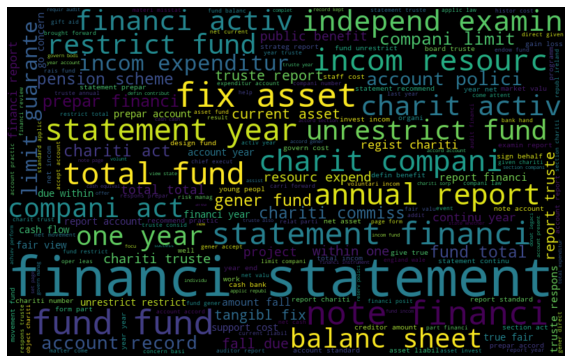

In [ ]:

# Word cloud stemmer
all_words = ' '.join([text for text in df['stemmer1']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500,stopwords= stop_words, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

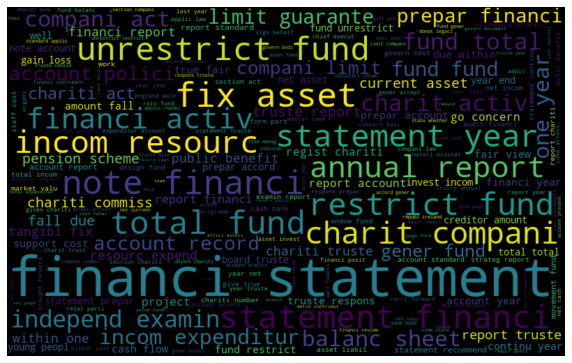

In [ ]:
# Word cloud stemmer
all_words = ' '.join([text for text in df['stemmer2']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500,stopwords= stop_words, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [ ]:
# Merge the tokens back
df['lmt1'] = df['lemmatize1'].apply(lambda x: ' '.join([w for w in x]))
df['lmt2'] = df['lemmatize2'].apply(lambda x: ' '.join([w for w in x]))
df.head(1)

filename  \
0  008482cf51383c158b54e593cfa5fbf7.pdf   

                                                keys  \
0  address__post_town address__postcode address__...   

                                           text_djvu  \
0  TAR\n1\nAugust 2016\nTrustees' Annual Report f...   

                                      text_tesseract  \
0  CHARITY Trustees’' Annual Report for the perio...   

                                       text_textract  \
0  [charity, trustees, annual, report, period, co...   

                                           text_best  \
0  [tar, trustees, annual, report, period, period...   

                                          lemmatize1  \
0  [charity, trustee, annual, report, period, com...   

                                          lemmatize2  \
0  [tar, trustee, annual, report, period, period,...   

                                            stemmer1  \
0  chariti truste annual report period commiss pe...   

                                            stemmer2  \
0  tar truste annual report period period start d...   

                                                lmt1  \
0  charity trustee annual report period commissio...   

                                                lmt2  
0  tar trustee annual report period period start ...

In [ ]:
df['lmt2'][0]

'tar trustee annual report period period start date period end date section reference administration detail charity pc nicola hughes memorial fund name charity known registered charity number charity principal address unit block gatehead business park delph new road oldham postcode ol de name charity trustee manage charity trustee office date acted whole year person body entitled appoint trustee bryndon hughes chair name trustee charity example custodian trustee date acted whole year richard bartlett mark brook tar name address adviser optional information type adviser address legal advisor john ainley north ainley halliwell solicitor clegg oldham ol p accountant david richardson richardson accountancy chief executive name senior staff member optional information bryndon hughes section structure governance management description charity trust type governing document trust constitution constitution charity constituted trust association company charitable incorporated organisation truste

In [ ]:

df['lmt2'][1]

'anv oa el qic receipt payment account ccca period start period end neriod section receipt payment unrestricte restricted endowment total fund last year fund fund fund nearest nearest nearest nearest nearest receipt payment show artiste expense printing advertsing trustee meeting venuehire workshop mentoring teaching cost administration cost sub total asset investment purchase table subtotal total payment let receiptspayments transfer betweenfun cashfunds lastyeare cashfunds thisyearend ccxx r account s fccxx r account s section statement asset liability end period unrestricte restricted endowmen category detail fund fund fund nearest nearestf nearest b cash fund jotal cash fund ok total cash fund receipt payment error error unrestricte restricted endowmen funde fiinde funde detail aare b monetary asset fund current cost asset value belongs optional optional detail fund cost current asset value belongs optional onal detail b asset retained charity fund amount due due optional liability

In [ ]:
df['lmt2'][111]

'judd school development fund registered charity report account year gtons chartered accountant high street battle east sussex judd school development fund report trustee year introduction judd school development fund registered charity number office trustee skinner hall dowgate hill london ecr sp constitution fund established trust dated remains governing document trust capital income applied primarily towards financing project capital nature connected judd school tonbridge grant made either school voluntary aided provision education act judd school foundation separate charity support school embrace endowment prize fund trust amended february appoint school managing trustee trustee trustee worshipful company skinner managing trustee trust empowers trustee appoint managing trustee following po sitions headmaster chau governor link governor deputy headmaster current trustee follows master headmaster leaby chair governor robin link governor deputy headmaster page judd school development 

### Word cloud for LMT

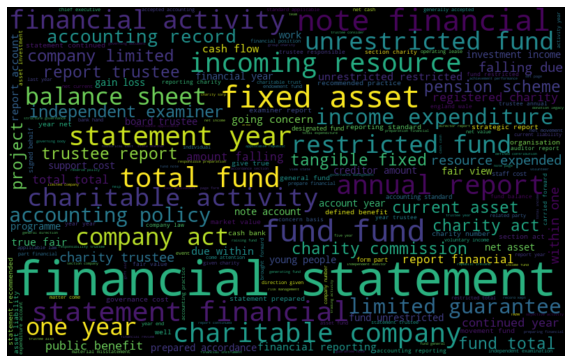

In [ ]:
# Word cloud lmt1
all_words = ' '.join([text for text in df['lmt1']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500,stopwords= stop_words, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

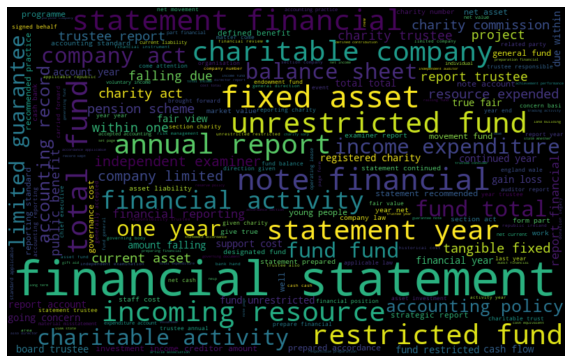

In [ ]:
# Word cloud lmt2
all_words = ' '.join([text for text in df['lmt2']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500,stopwords= stop_words, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

# Vectorize the data

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
tfidf = TfidfVectorizer(
    min_df = 0.1,
    max_df = 0.8,
    max_features = 50000000,
    stop_words = stop_words
    # stop_words = stopwords.words('english')   # For checking with and without english SW
)

In [ ]:
tfidf.fit(df['lmt1'].dropna())
text1 = tfidf.transform(df['lmt1'].dropna()) # text1 for textract 

tfidf.fit(df['lmt2'].dropna())
text2 = tfidf.transform(df['lmt2'].dropna()) # text2 for best

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eliot'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
text1  #with english stop words

<1729x1862 sparse matrix of type '<class 'numpy.float64'>'
	with 907625 stored elements in Compressed Sparse Row format>

In [ ]:
text2.shape

(1729, 1841)

# Hyperparameter tuning for optimal number of clusters¶

In [ ]:
max_k=30
data=text2
iters = range(4, max_k+1, 2)

sse = []
for k in iters:
    sse_val = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_
    sse.append(sse_val)
    print('Fit {} clusters, sse {}'.format(k,sse_val))

Fit 4 clusters, sse 1257.4453252084545
Fit 6 clusters, sse 1184.5887143109096
Fit 8 clusters, sse 1140.687677598789
Fit 10 clusters, sse 1139.2389533623177
Fit 12 clusters, sse 1112.8709092183717
Fit 14 clusters, sse 1107.4639980638349
Fit 16 clusters, sse 1086.326942243418
Fit 18 clusters, sse 1084.4497539751565
Fit 20 clusters, sse 1061.2243703034214
Fit 22 clusters, sse 1052.626262421285
Fit 24 clusters, sse 1048.2482678350425
Fit 26 clusters, sse 1019.4592578271955
Fit 28 clusters, sse 1011.6285248970655
Fit 30 clusters, sse 1001.3899570397324


# Plot SSE vs number of clusters

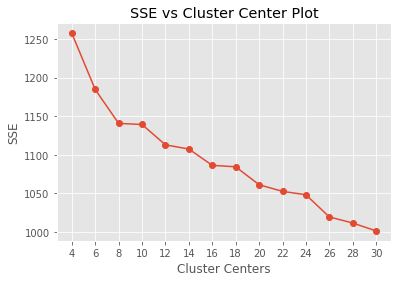

In [ ]:
plt.style.use("ggplot")
f, ax = plt.subplots(1, 1)
ax.plot(iters, sse, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('SSE')
ax.set_title('SSE vs Cluster Center Plot')
plt.savefig('/content/Clustering-SSE.png')
plt.show()

# Model for optimal number of clusters

In [ ]:
clusters = MiniBatchKMeans(n_clusters=20, init_size=1024, batch_size=2048, random_state=20).fit_predict(text2)

# Print clusters with top terms

In [ ]:
labels=tfidf.get_feature_names()
n_terms=20

new_df = pd.DataFrame(data.todense())
new_df['clusters'] = clusters
# new_df.to_csv('/content/clusters.csv')

In [ ]:
new_df.shape

(1729, 1842)

In [ ]:

clusters_mean = new_df.groupby(['clusters']).mean()

In [ ]:
clusters_mean.shape

(20, 1841)

In [ ]:
clusters_mean.head(20)

0         1         2         3         4         5     \
clusters                                                               
0         0.009357  0.012041  0.002250  0.035354  0.009523  0.004601   
1         0.001937  0.008454  0.000246  0.000171  0.001623  0.002271   
2         0.003579  0.009963  0.001280  0.001684  0.002968  0.002709   
3         0.013358  0.012039  0.003188  0.001653  0.015253  0.005243   
4         0.005894  0.015475  0.000146  0.000754  0.001938  0.003437   
5         0.005178  0.010022  0.000532  0.003306  0.000000  0.007187   
6         0.008973  0.008456  0.003094  0.065924  0.008673  0.003457   
7         0.005359  0.009316  0.001277  0.001479  0.003045  0.002940   
8         0.002925  0.011895  0.000000  0.008460  0.000786  0.002789   
9         0.000000  0.011049  0.000000  0.000000  0.000000  0.000000   
10        0.009017  0.006891  0.003444  0.004582  0.000812  0.011839   
11        0.004179  0.005283  0.000000  0.000000  0.001734  0.000702   
12        0.003551  0.007989  0.000857  0.002563  0.000000  0.002426   
13        0.001621  0.008191  0.004112  0.001423  0.000000  0.000577   
14        0.005387  0.009239  0.002792  0.001873  0.004670  0.003737   
15        0.011057  0.016101  0.001379  0.006455  0.020438  0.003195   
16        0.003000  0.014880  0.001980  0.000587  0.005678  0.001662   
17        0.001532  0.004780  0.000000  0.000000  0.000000  0.001947   
18        0.005093  0.021632  0.000000  0.004610  0.000000  0.000741   
19        0.003648  0.011067  0.007322  0.005074  0.000773  0.003982   

              6         7         8         9         10        11    \
clusters                                                               
0         0.008246  0.014058  0.002263  0.003589  0.006092  0.003459   
1         0.005169  0.003947  0.001413  0.002755  0.010254  0.003211   
2         0.005746  0.005841  0.001063  0.003804  0.015779  0.002201   
3         0.012897  0.011357  0.003173  0.012917  0.000540  0.002292   
4         0.011143  0.015973  0.004778  0.008141  0.008673  0.003506   
5         0.012351  0.008311  0.001665  0.000000  0.009133  0.001479   
6         0.007558  0.012490  0.001418  0.013679  0.000000  0.007296   
7         0.010507  0.009423  0.001332  0.003516  0.009843  0.003568   
8         0.002300  0.005878  0.001167  0.000000  0.019026  0.000000   
9         0.000000  0.000000  0.000000  0.011442  0.005202  0.000000   
10        0.030204  0.003289  0.001238  0.005063  0.002653  0.004988   
11        0.003195  0.001196  0.001546  0.000292  0.013090  0.002018   
12        0.004484  0.005308  0.003489  0.001900  0.010321  0.001297   
13        0.000000  0.005572  0.000913  0.000393  0.015539  0.002848   
14        0.008130  0.014284  0.011955  0.001631  0.005895  0.000594   
15        0.007208  0.018997  0.003991  0.009901  0.002013  0.002597   
16        0.001842  0.005816  0.001563  0.002264  0.011531  0.003860   
17        0.003997  0.002719  0.000000  0.000000  0.020129  0.001711   
18        0.004568  0.004060  0.007664  0.002989  0.003489  0.000670   
19        0.007725  0.003426  0.001530  0.009056  0.016634  0.002001   

              12        13        14        15        16        17    \
clusters                                                               
0         0.003555  0.003172  0.007943  0.009341  0.008951  0.006183   
1         0.001557  0.007160  0.012958  0.016304  0.006872  0.003758   
2         0.002108  0.010756  0.016187  0.006135  0.011566  0.004166   
3         0.005348  0.001185  0.004244  0.009152  0.010798  0.007372   
4         0.002633  0.010972  0.020497  0.005548  0.011877  0.004757   
5         0.002431  0.006755  0.014366  0.007429  0.013325  0.003881   
6         0.004971  0.000130  0.001863  0.011191  0.004123  0.007948   
7         0.003519  0.011740  0.025709  0.009937  0.016121  0.006783   
8         0.000000  0.000638  0.011377  0.002356  0.003930  0.002438   
9         0.000000  0.000000  0.013066  0.014133  0.

In [ ]:
for i,r in clusters_mean.iterrows():
    print('\nCluster {}'.format(i))
    print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))


Cluster 0
student,group,restricted,limited,auditor,child,contribution,girl,staff,trust,parent,teacher,education,pension,investment,scheme,bursary,company,pupil,school

Cluster 1
property,incoming,building,hall,sunday,group,john,examination,people,council,investment,examiner,community,service,restricted,mission,ministry,christian,parish,church

Cluster 2
school,come,value,child,service,hall,trust,new,community,incoming,committee,foundation,payment,receipt,attention,investment,restricted,grant,examination,examiner

Cluster 3
continued,staff,contribution,fixed,director,people,limited,auditor,value,investment,property,home,board,care,pension,group,scheme,service,housing,company

Cluster 4
living,local,staff,organisation,continued,investment,examiner,advice,health,people,project,limited,restricted,friend,voluntary,community,hospital,service,company,centre

Cluster 5
incoming,west,receipt,student,council,president,organisation,new,company,committee,building,examination,investment,grant,exam

# Visulaization FCA

In [ ]:
from sklearn.decomposition import FactorAnalysis
FA = FactorAnalysis(n_components = 3).fit_transform(clusters_mean.values)

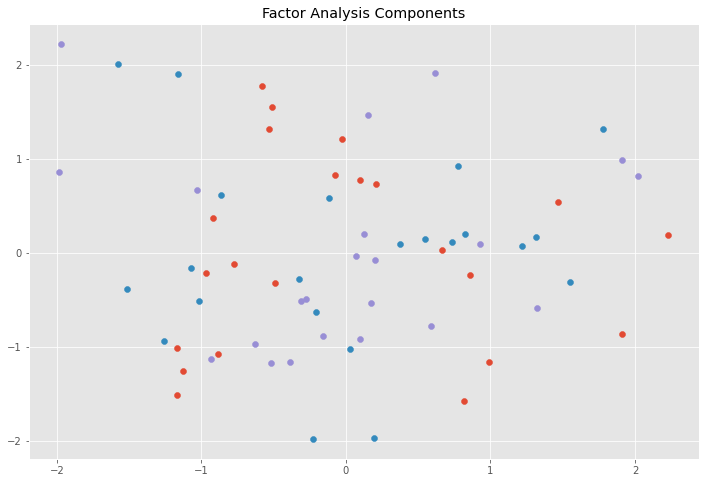

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Factor Analysis Components')
plt.scatter(FA[:,0], FA[:,1])
plt.scatter(FA[:,1], FA[:,2])
plt.scatter(FA[:,2],FA[:,0])

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(clusters_mean.values)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

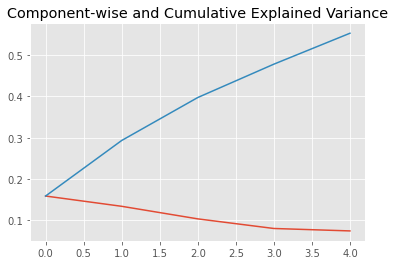

In [ ]:
plt.plot(range(5), pca.explained_variance_ratio_)
plt.plot(range(5), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In the above graph, the blue line represents component-wise explained variance while the orange line represents the cumulative explained variance. We are able to explain around 50% variance in the dataset using just 3 components. Let us now try to visualize each of these decomposed components:

# Methods Based on Projections

Parameters used:

n_neighbors decides the number of neighbors for each point
n_components decides the number of coordinates for manifold
n_jobs = -1 will use all the CPU cores available

In [ ]:
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5, n_components=3, n_jobs=-1).fit_transform(clusters_mean.values)

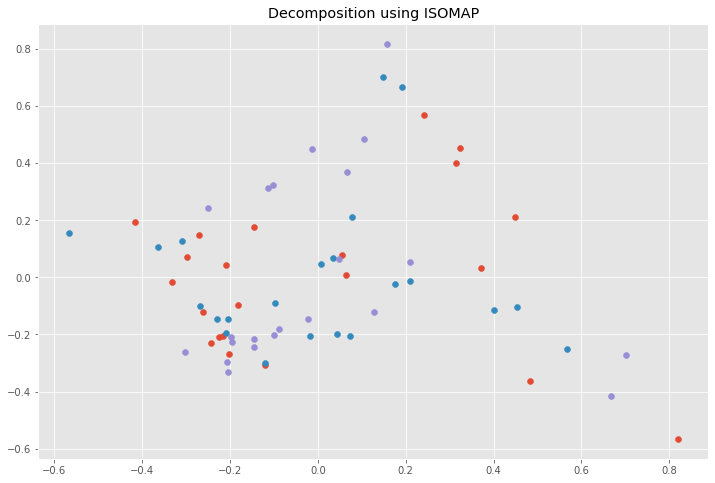

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using ISOMAP')
plt.scatter(trans_data[:,0], trans_data[:,1])
plt.scatter(trans_data[:,1], trans_data[:,2])
plt.scatter(trans_data[:,2], trans_data[:,0])

# t- Distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=3, n_iter=300).fit_transform(clusters_mean.values)

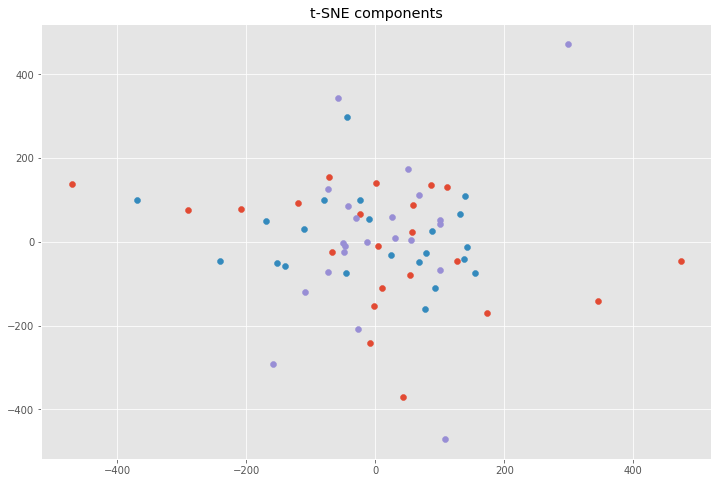

In [ ]:
plt.figure(figsize=(12,8))
plt.title('t-SNE components')
plt.scatter(tsne[:,0], tsne[:,1])
plt.scatter(tsne[:,1], tsne[:,2])
plt.scatter(tsne[:,2], tsne[:,0])

### Trying K-Means and DBScan after TFIDF

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words)   #(stop_words=stopwords.words('english'))

X1 = vectorizer.fit_transform(df['lmt1'])
X2 = vectorizer.fit_transform(df['lmt2'])

In [ ]:
X1.shape

(1729, 75110)

In [ ]:
X2.shape

(1729, 122988)

In [ ]:
from sklearn.cluster import KMeans

number_of_clusters = 20

model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init=1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

model.fit(text1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=20, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [ ]:
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 abnormality
 activate
 accountan
 aacounts
 activitim
 acoults
 acliuines
 acouals
 abdal
 acarunts
Cluster 1:
 aciiviiies
 accourrling
 acailemic
 aaea
 actress
 aaccess
 accountsii
 accom
 actu
 acrodance
Cluster 2:
 abilit
 acheck
 abilily
 abnormality
 abnormal
 accom
 accorarferg
 activet
 accolntents
 acliuines
Cluster 3:
 acuvltles
 accom
 accolntents
 accountsssl
 accessibly
 abiilties
 aaounts
 activitiesfchanning
 absence
 acfively
Cluster 4:
 accountingtconventiont
 accouivtinc
 acuvltles
 abnormality
 accountanttpetertmackenzietwhotistresidenttintmandritsaratfortonetyearttintoctobertt
 accnacy
 activitim
 accuracyat
 adcquatc
 abstraction
Cluster 5:
 abnormality
 acbvibes
 accountancyfees
 accom
 accolntents
 accountsssl
 activet
 acuvltles
 actionwide
 accumulate
Cluster 6:
 accountan
 abnormal
 acliuines
 adattod
 activitim
 accom
 acoults
 achievemev
 acrodance
 abf
Cluster 7:
 ablazes
 acuvltles
 abnormality
 accom
 accotinte
 accolntents
 activet
 aboard
 a

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
# X1 = X1.todense() # <-- This line was needed to resolve the issue
# db = DBSCAN(eps=0.2, min_samples=50).fit(text1)
# db

In [ ]:
dbscan_clstr = DBSCAN(eps=0.3, min_samples=4)
dbscan_clstr.fit(text1)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=4, n_jobs=None, p=None)

In [ ]:
df['dbscan_label'] = dbscan_clstr.labels_

In [ ]:
print(f'{df["dbscan_label"].nunique() - 1} Clusters')
print(f'{df[df["dbscan_label"] == -1].shape[0]} Outliers')

19 Clusters
1639 Outliers


In [ ]:
df.head(2)

filename  \
0  008482cf51383c158b54e593cfa5fbf7.pdf   
1  009fab39d746267b6de8428366fe4b02.pdf   

                                                keys  \
0  address__post_town address__postcode address__...   
1  address__post_town address__postcode address__...   

                                           text_djvu  \
0  TAR\n1\nAugust 2016\nTrustees' Annual Report f...   
1  \fAnnual Report 2015-2017 July, 2017\nStepping...   

                                      text_tesseract  \
0  CHARITY Trustees’' Annual Report for the perio...   
1  \n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...   

                                       text_textract  \
0  [charity, trustees, annual, report, period, co...   
1  [charity, lif, anv, stepping, stone, theatre, ...   

                                           text_best  \
0  [tar, trustees, annual, report, period, period...   
1  [anv, oa, el, qic, receipts, payments, account...   

                                          lemmatize1  \
0  [charity, trustee, annual, report, period, com...   
1  [charity, lif, anv, stepping, stone, theatre, ...   

                                          lemmatize2  \
0  [tar, trustee, annual, report, period, period,...   
1  [anv, oa, el, qic, receipt, payment, account, ...   

                                            stemmer1  \
0  chariti truste annual report period commiss pe...   
1  chariti lif anv step stone theatr receipt paym...   

                                            stemmer2  \
0  tar truste annual report period period start d...   
1  anv oa el qic receipt payment account ccca per...   

                                                lmt1  \
0  charity trustee annual report period commissio...   
1  charity lif anv stepping stone theatre receipt...   

                                                lmt2  dbscan_label  
0  tar trustee annual report period period start ...            -1  
1  anv oa el qic receipt payment account ccca per...            -1

In [ ]:
df['dbscan_label'].value_counts()

-1     1639
 0        9
 1        7
 8        5
 15       5
 4        5
 5        5
 9        5
 14       5
 11       4
 10       4
 18       4
 12       4
 7        4
 6        4
 13       4
 3        4
 2        4
 17       4
 16       4
Name: dbscan_label, dtype: int64

# Another Try

In [ ]:
'''# Build DBSCAN model with Tf-idf vectorizer
tfidfvec = TfidfVectorizer(ngram_range=(1,3), min_df = 0.2, max_df = 0.7, decode_error = "ignore")

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.15, stop_words=stop_words,
                                 use_idf=True, ngram_range=(1,3))'''

In [ ]:
# Build DBSCAN model with Tf-idf vectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2000000,
                                 min_df=0.15, stop_words=stop_words,
                                 use_idf=True)

In [ ]:
X2 = tfidf_vectorizer.fit_transform(df['lmt2']).toarray()

In [ ]:
X2.shape

(1729, 1341)

In [ ]:
X2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.03703913,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03912318],
       [0.21467642, 0.00672727, 0.        , ..., 0.00362804, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06958351],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10819556,
        0.        ],
       [0.        , 0.01498951, 0.        , ..., 0.        , 0.        ,
        0.0213107 ]])

In [ ]:
dbs = DBSCAN(eps=0.75, min_samples=4).fit(text1)
core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True
labels1 = dbs.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print(labels1)
print(n_clusters_)

clusters1 = {}
for c, i in enumerate(labels1):
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( text2[c] )
    else:
        clusters1[i] = [text2[c]]
'''for c in clusters1:
    print(clusters1[c])
    print()'''

[ 0 -1  1 ... 52 64 -1]
95


'for c in clusters1:\n    print(clusters1[c])\n    print()'

In [ ]:
df['dbscan_label'] = dbs.labels_

In [ ]:
print(f'{df["dbscan_label"].nunique() - 1} Clusters')
print(f'{df[df["dbscan_label"] == -1].shape[0]} Outliers')

95 Clusters
999 Outliers


In [ ]:
df['dbscan_label'] = dbs.labels_
#print(dbs.labels_)
print(np.unique(dbs.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]


In [ ]:
labels = dbs.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbs.core_sample_indices_] = True

In [ ]:
df["dbscan_label"].value_counts()

-1     999
 5      89
 4      56
 0      50
 9      45
      ... 
 63      4
 65      4
 27      4
 25      4
 91      4
Name: dbscan_label, Length: 96, dtype: int64

# Visualization

In [ ]:
import numpy as np
import scipy.sparse
import sympy
import sklearn.datasets
import sklearn.feature_extraction.text
import umap
import umap.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pip install umap

In [ ]:
X2.shape

(1729, 1341)

In [ ]:
#mapper = umap.UMAP(metric='hellinger', random_state=42, low_memory=True).fit(X2)

In [ ]:
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(X2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


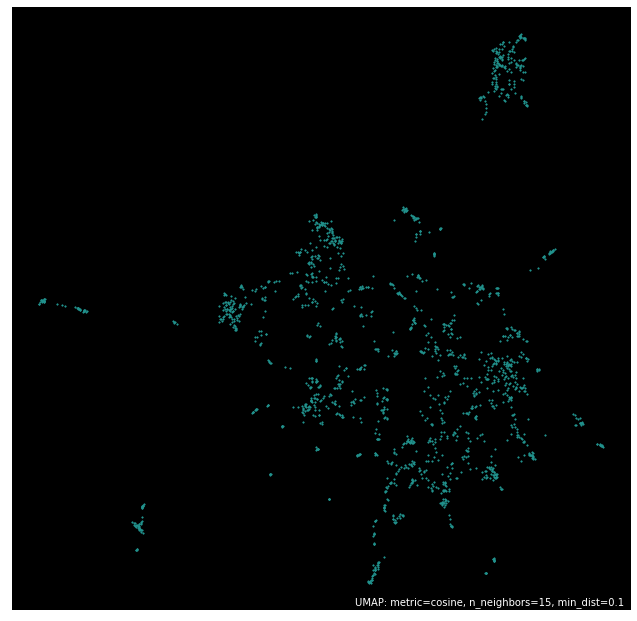

In [ ]:
umap.plot.points(mapper, theme='viridis')

## Reducing the number of paramters

In [ ]:
svd = TruncatedSVD(n_components=1000, random_state=0)
small_vector = svd.fit_transform(X2)

small_vector.shape

(1729, 1000)

In [ ]:
pip install hdbscan

     |████████████████████████████████| 4.7MB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301843 sha256=d559083e1561ed23071c7a82cb48cd55f5648a9592bcde1b9ae0f5ff412f0146
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


## Trying HDBSCAN

HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=40, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

In [ ]:

import hdbscan
from collections import Counter

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    cluster_selection_epsilon=0.5,
    min_samples=4
)

In [ ]:
clusterer.fit(small_vector)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.5,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=4, p=None,
        prediction_data=False)

In [ ]:
hdblabel = clusterer.labels_
n_clusters_ = len(set(hdblabel)) - (1 if -1 in hdblabel else 0)
print("Total cluster :",n_clusters_)

Total cluster : 64


In [ ]:
hdb_label = Counter(hdblabel)
hdb_label.most_common(10)

[(-1, 1042),
 (36, 101),
 (54, 56),
 (26, 55),
 (50, 45),
 (59, 26),
 (32, 20),
 (62, 20),
 (38, 12),
 (57, 12)]

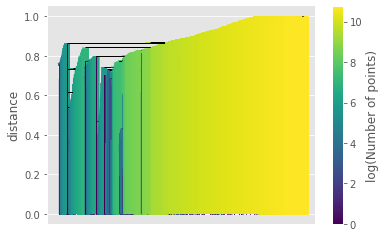

In [ ]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

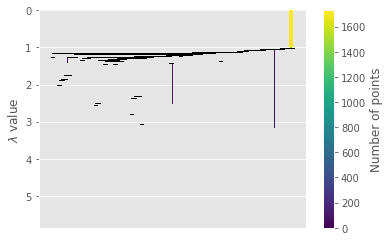

In [ ]:
clusterer.condensed_tree_.plot()

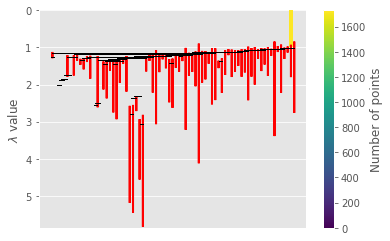

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
clusterer.outlier_scores_

array([0.09793035, 0.00091764, 0.43235578, ..., 0.        , 0.        ,
       0.00152548])

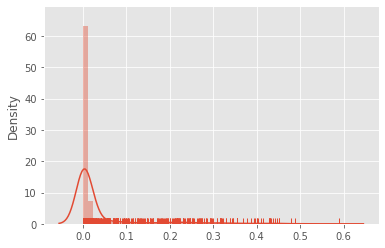

In [ ]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

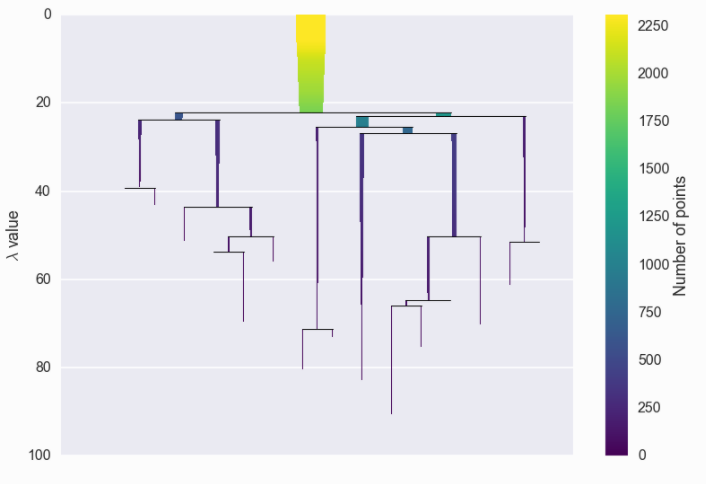

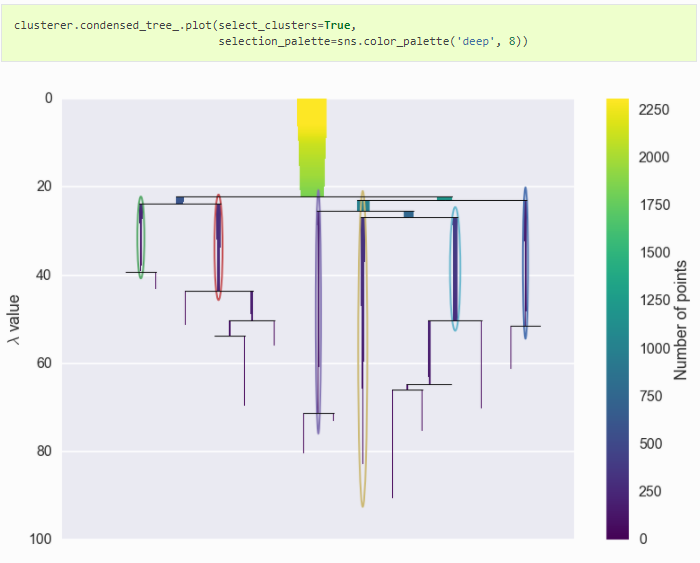

# Trying cosine 

### dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each doc among the docs). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more docs.

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(text2)
dist.shape

(1729, 1729)

## K-means clustering (cosine similarity)

In [ ]:

from sklearn.cluster import KMeans

num_clusters = 20

km = KMeans(n_clusters=num_clusters)

%time km.fit(dist)

clusters = km.labels_.tolist()

CPU times: user 4.72 s, sys: 1.45 s, total: 6.17 s
Wall time: 3.85 s


In [ ]:
max_k=30
data=dist
iters = range(4, max_k+1, 2)

sse = []
for k in iters:
    sse_val = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_
    sse.append(sse_val)
    print('Fit {} clusters, sse {}'.format(k,sse_val))

Fit 4 clusters, sse 17969.319474591925
Fit 6 clusters, sse 14764.28082941673
Fit 8 clusters, sse 12457.155382293106
Fit 10 clusters, sse 11303.546762965714
Fit 12 clusters, sse 10946.437267173813
Fit 14 clusters, sse 10505.574246131724
Fit 16 clusters, sse 9905.968813796557
Fit 18 clusters, sse 9622.110211543586
Fit 20 clusters, sse 9392.368995736242
Fit 22 clusters, sse 9089.340408624459
Fit 24 clusters, sse 8704.235574053764
Fit 26 clusters, sse 8517.49029962293
Fit 28 clusters, sse 8278.849507119063
Fit 30 clusters, sse 8097.784035198492


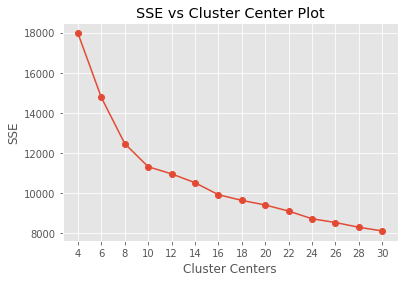

In [ ]:
plt.style.use("ggplot")
f, ax = plt.subplots(1, 1)
ax.plot(iters, sse, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('SSE')
ax.set_title('SSE vs Cluster Center Plot')
plt.savefig('/content/Clustering-SSE.png')
plt.show()

## HDBSCAN on Cosine Similarity

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    cluster_selection_epsilon=2.5,
    #cluster_selection_method='leaf',
    min_samples=4
)

In [ ]:
clusterer.fit(dist)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=2.5,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=4, p=None,
        prediction_data=False)

In [ ]:
clusterer.labels_

array([7, 7, 7, ..., 7, 7, 7])

In [ ]:
clusterer.labels_.max()

8

In [ ]:
clusterer.probabilities_

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
hdblabel = clusterer.labels_
n_clusters_ = len(set(hdblabel)) - (1 if -1 in hdblabel else 0)
print("Total cluster :",n_clusters_)

Total cluster : 9


In [ ]:
hdb_label = Counter(hdblabel)
hdb_label.most_common(10)


[(7, 1435),
 (-1, 152),
 (5, 62),
 (0, 44),
 (6, 9),
 (4, 7),
 (8, 5),
 (3, 5),
 (1, 5),
 (2, 5)]

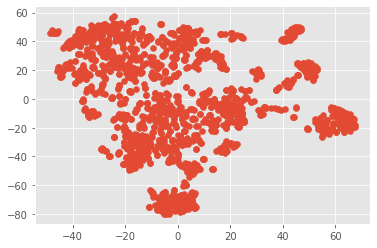

In [ ]:
projection = TSNE().fit_transform(dist) # With tf-idf and Cosine
plt.scatter(*projection.T)

Clearly visible from the plots that tf-idf with cosine similary will works better for clustering.

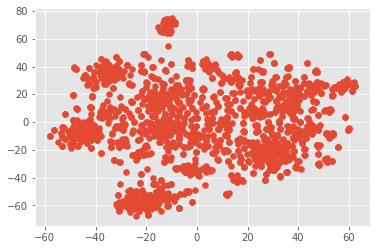

In [ ]:
projection2 = TSNE().fit_transform(X2) # With tf-idf
plt.scatter(*projection2.T)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


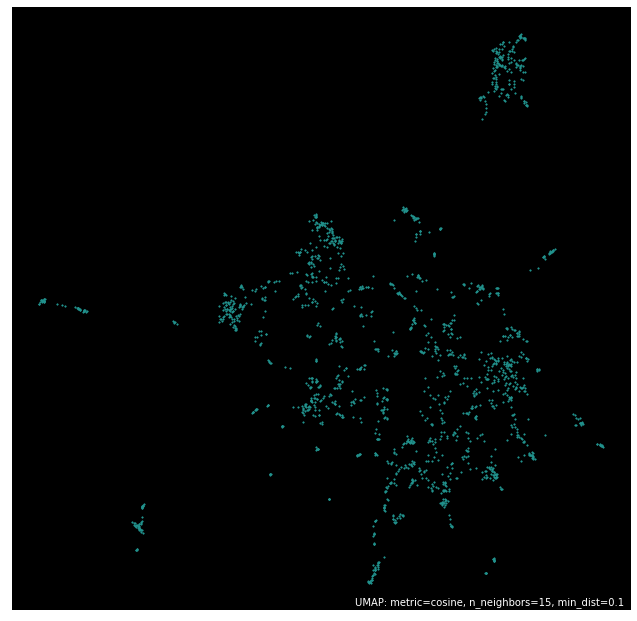

In [ ]:
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(X2)  # With tf-idf
umap.plot.points(mapper, theme='viridis')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


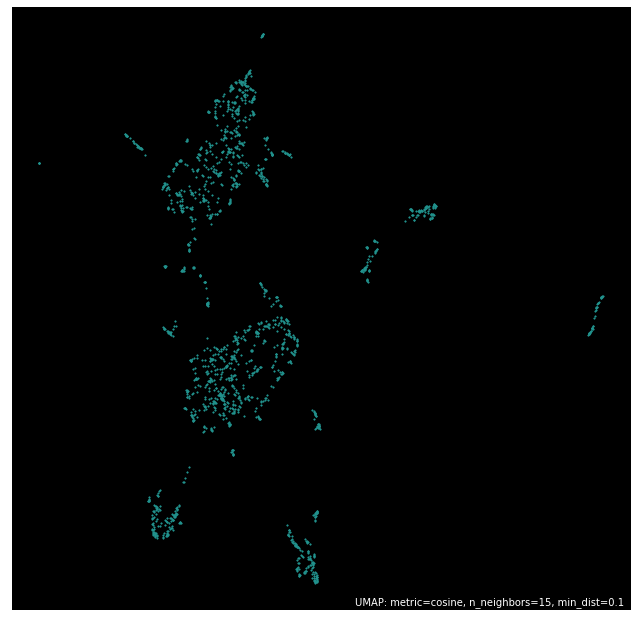

In [ ]:
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(dist)  # With tf-idf and Cosine
umap.plot.points(mapper, theme='viridis')
